In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)

In [10]:
col_meas = inspector.get_columns('measurement')
for column in col_meas:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_dt = dt.datetime.strptime(latest, '%Y-%m-%d')
print(latest)

2017-08-23


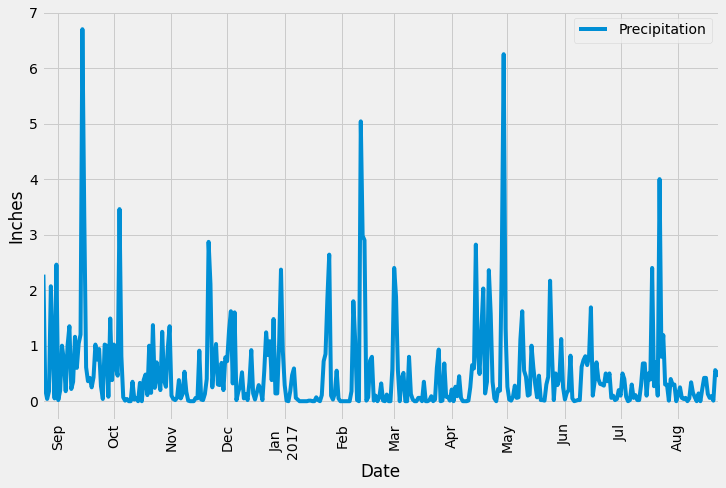

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = latest_dt - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
#Using the maximum value for precipitation on each date since this database includes the data from all the stations. 
msr_data = session.query(Measurement.date,func.max(Measurement.prcp)).\
    filter(Measurement.date <= latest_dt).\
    filter(Measurement.date > year_ago).\
    group_by(Measurement.date).\
    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
meas_df = pd.DataFrame(msr_data, columns=['Date', 'Precipitation'])
meas_df['Date'] = pd.to_datetime(meas_df['Date'], format = '%Y-%m-%d')
meas_df.set_index('Date', inplace= True)
# Sort the dataframe by date
meas_df.sort_index(inplace=True)
meas_df

# Use Pandas Plotting with Matplotlib to plot the data
meas_df.plot(figsize = (10,7), use_index =True, rot = 90, legend = True, xlim = (year_ago, latest_dt))
plt.tight_layout()
plt.ylabel("Inches")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
meas_df.agg(['mean', 'median' ,'var', 'std', 'sem'])

,Precipitation
mean,0.517288
median,0.250000
var,0.687567
std,0.829196
sem,0.043402


# Exploratory Station Analysis

In [14]:
col_sta = inspector.get_columns('station')
for column in col_sta:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [21]:
# Design a query to calculate the total number stations in the dataset
stat_num = session.query(Station.station).distinct().count()
print(f"There are {stat_num} unique stations.")

There are 9 unique stations.


In [31]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
act_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

act_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_act = act_count[0][0]
sta_stats = session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == top_act).all()
print(f"The maximum temperature is {sta_stats[0][0]} F, the minimum {sta_stats[0][1]} F and the average {sta_stats[0][2]} F")

The maximum temperature is 85.0 F, the minimum 54.0 F and the average 71.66378066378067 F


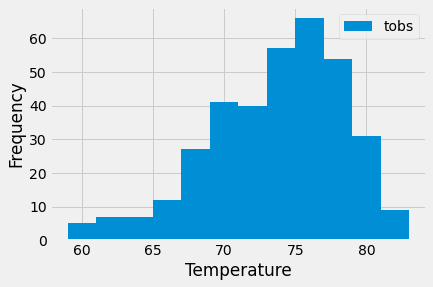

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
act_lat = session.query(Measurement.date).\
    filter(Measurement.station == top_act).\
    order_by(Measurement.date.desc()).first()[0]

act_lat_dt = dt.datetime.strptime(act_lat, '%Y-%m-%d')

hist_data = session.query(Measurement.tobs).\
    filter(Measurement.date <= act_lat_dt).\
    filter(Measurement.date > (act_lat_dt - dt.timedelta(days = 365))).\
    filter(Measurement.station == top_act).\
    all()

clean_hist = []

for row in hist_data:
    clean_hist.append(row[0])

plt.hist(clean_hist, bins = 12, label="tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()

# Close session

In [59]:
# Close Session
session.close()